## Notebook 01: SICAPv2 Dataset Exploration 
We'll use only Val1 for the exploration. 

All folds are subsets of the image and masks.

In [1]:
import os
import sys
import numpy as np
import random
from PIL import Image
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict

In [2]:
# Linking the paths to make sure we can import from src
project_root = os.path.abspath("..")
src_path = os.path.join(project_root, "src")
data_root = os.path.join(project_root, "data", "SICAPv2")

print("Project root:", project_root)
print("SRC path:    ", src_path)
print("Data root:   ", data_root)

if src_path not in sys.path:
    sys.path.append(src_path)

Project root: /Users/rkakooza/Desktop/sicapv2-gleason-segmentation
SRC path:     /Users/rkakooza/Desktop/sicapv2-gleason-segmentation/src
Data root:    /Users/rkakooza/Desktop/sicapv2-gleason-segmentation/data/SICAPv2


In [3]:
from dataset import build_dataset_from_partition

# Paths to Val1 partition Excel files
val1_train = os.path.join(data_root, "partition", "Validation", "Val1", "Train.xlsx")
val1_test  = os.path.join(data_root, "partition", "Validation", "Val1", "Test.xlsx")

# print("Train XLSX:", val1_train)
# print("Test XLSX: ", val1_test)

# Build datasets
train_ds = build_dataset_from_partition(val1_train, data_root)
test_ds  = build_dataset_from_partition(val1_test, data_root)

print("Dataset sizes:")
print("Train:", len(train_ds))
print("Test: ", len(test_ds))

Dataset sizes:
Train: 7472
Test:  2487


Check that masks alighn properly

Image shape: torch.Size([3, 512, 512])
Mask shape: torch.Size([512, 512])
Unique mask values: tensor([0, 1, 2, 3])
Min: 0 Max: 3

Image path: /Users/rkakooza/Desktop/sicapv2-gleason-segmentation/data/SICAPv2/images/17B0016583_Block_Region_3_17_15_xini_43506_yini_101325.jpg
Mask path : /Users/rkakooza/Desktop/sicapv2-gleason-segmentation/data/SICAPv2/masks/17B0016583_Block_Region_3_17_15_xini_43506_yini_101325.jpg


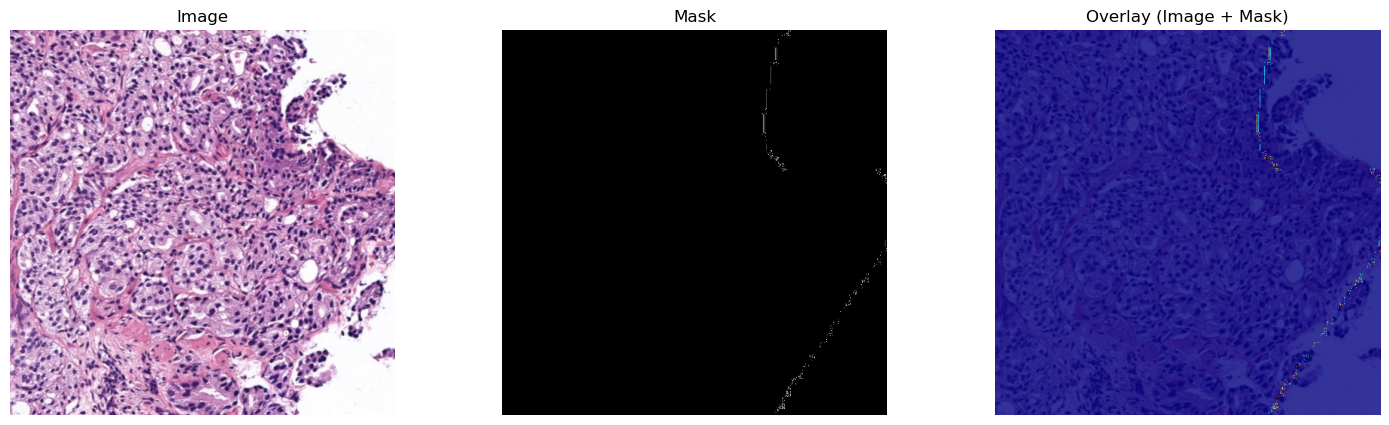

Saved combined image to: /Users/rkakooza/Desktop/sicapv2-gleason-segmentation/report/figures/dataset_samples/sample_1159.png


In [4]:
# Pick random sample
idx = random.randint(0, len(train_ds)-1)

image, mask = train_ds[idx]

print("Image shape:", image.shape)
print("Mask shape:", mask.shape)
print("Unique mask values:", torch.unique(mask))
print("Min:", mask.min().item(), "Max:", mask.max().item())

img_path = train_ds.image_paths[idx]
mask_path = train_ds.mask_paths[idx]

print("\nImage path:", img_path)
print("Mask path :", mask_path)

img_np = image.permute(1, 2, 0).numpy()
mask_np = mask.numpy()

# Plot and Save image, mask and overly

save_dir = os.path.join(project_root, "report", "figures", "dataset_samples")
os.makedirs(save_dir, exist_ok=True)

save_path = os.path.join(save_dir, f"sample_{idx}.png")

fig = plt.figure(figsize=(18, 5))

# Image
ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(img_np)
ax1.set_title("Image")
ax1.axis("off")

# Mask
ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(mask_np, cmap="gray")
ax2.set_title("Mask")
ax2.axis("off")

# Overlay
ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(img_np)
ax3.imshow(mask_np, cmap="jet", alpha=0.8)
ax3.set_title("Overlay (Image + Mask)")
ax3.axis("off")

# Show it notebook
plt.show()

# Save the entire thing as one image
fig.savefig(save_path, bbox_inches="tight", pad_inches=0)
plt.close(fig)

print("Saved combined image to:", save_path)

Class Distribution

In [5]:
# Count pixels for classes 0–3
num_classes = 4
pixel_counts = np.zeros(num_classes, dtype=np.int64)

print("Pixel distribution over Val1 Train")

for img, mask in tqdm(train_ds):
    mask_np = mask.numpy().flatten()
    for c in range(num_classes):
        pixel_counts[c] += np.sum(mask_np == c)

pixel_counts, pixel_counts.sum()

Pixel distribution over Val1 Train


100%|██████████| 7472/7472 [00:26<00:00, 278.68it/s]


(array([1954665688,    1626109,    1312409,    1135762]), np.int64(1958739968))

Pixel counts: [1954665688    1626109    1312409    1135762]
Percentages: [9.97919949e+01 8.30181150e-02 6.70027171e-02 5.79843174e-02]


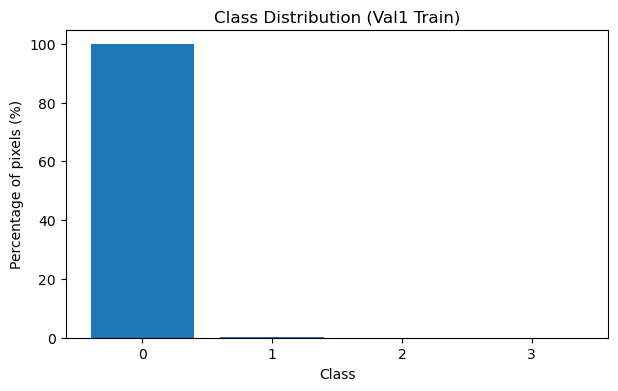

In [6]:
total_pixels = pixel_counts.sum()
percentages = (pixel_counts / total_pixels) * 100

print("Pixel counts:", pixel_counts)
print("Percentages:", percentages)

plt.figure(figsize=(7,4))
plt.bar(range(num_classes), percentages, tick_label=[0,1,2,3])
plt.title("Class Distribution (Val1 Train)")
plt.xlabel("Class")
plt.ylabel("Percentage of pixels (%)")
plt.show()

In [7]:
# Lets see how classes are distributed in patches
class_indices = defaultdict(list)

print("Scanning dataset for class occurrences...")
for i in range(len(train_ds)):
    _, mask = train_ds[i]
    unique_vals = torch.unique(mask).tolist()
    for c in unique_vals:
        class_indices[c].append(i)

for c in range(4):
    print(f"Class {c}: {len(class_indices[c])} patches contain this class")

Scanning dataset for class occurrences...
Class 0: 7472 patches contain this class
Class 1: 4380 patches contain this class
Class 2: 4380 patches contain this class
Class 3: 4379 patches contain this class


From the above, we can confirm that all Gleason grades appear and it shows that cancer is present in many patches.

This also helps us understand patch-level vs pixel-level imbalance. Maybe we don't need it but can mention it in the report

Computing Class Weights

In [8]:
folds = ["Val1", "Val2", "Val3", "Val4"]
num_classes = 4

pixel_counts = np.zeros(num_classes, dtype=np.int64)

for fold in folds:
    print(f"\nProcessing {fold} Train partition...")
    train_xlsx = os.path.join(
        data_root, "partition", "Validation", fold, "Train.xlsx"
    )
    
    ds = build_dataset_from_partition(train_xlsx, data_root, transform=None)
    print(f"{fold} Train size: {len(ds)} patches")

    for _, mask in tqdm(ds):
        mask_np = mask.numpy().flatten()
        for c in range(num_classes):
            pixel_counts[c] += np.sum(mask_np == c)

print("\nTotal pixel counts across all 4 folds (Train only):")
print(pixel_counts)


Processing Val1 Train partition...
Val1 Train size: 7472 patches


100%|██████████| 7472/7472 [00:26<00:00, 283.88it/s]



Processing Val2 Train partition...
Val2 Train size: 7793 patches


100%|██████████| 7793/7793 [00:27<00:00, 288.58it/s]



Processing Val3 Train partition...
Val3 Train size: 8166 patches


100%|██████████| 8166/8166 [00:28<00:00, 285.33it/s]



Processing Val4 Train partition...
Val4 Train size: 6446 patches


100%|██████████| 6446/6446 [00:23<00:00, 275.11it/s]


Total pixel counts across all 4 folds (Train only):
[7813755639    7246236    5904123    5170290]


In [ ]:
total_pixels = pixel_counts.sum()
freq = pixel_counts / total_pixels

print("Class frequencies:", freq)

# Inverse-frequency weights
inv_freq = 1.0 / (freq + 1e-8)

# Normalize so the smallest weight is 1.0
class_weights = inv_freq / inv_freq.min()

print("\nInverse-frequency class weights (normalized):")
for c, w in enumerate(class_weights):
    print(f"Class {c}: weight = {w:.4f}")

class_weights_list = class_weights.tolist()
class_weights_list

Class frequencies: [9.97660818e-01 9.25199875e-04 7.53838801e-04 6.60142957e-04]

Inverse-frequency class weights (normalized):
Class 0: weight = 1.0000
Class 1: weight = 1078.3076
Class 2: weight = 1323.4230
Class 3: weight = 1511.2571


[1.0, 1078.3075880288538, 1323.4229818422164, 1511.2570773619188]

These weights are too large and can't be used in CrossEntropyLoss. They will destabilize training and force the model into extreme gradients.

Logistic Compression
> Formula: w_c = 1 + log(1 + inv_freq_c)

In [12]:
raw = np.array([1.0, 1078.3076, 1323.4230, 1511.2571])
# raw = np.array([1.0, 1078.3075880288538, 1323.4229818422164, 1511.2570773619188])
safe = 1 + np.log(1 + raw)

safe

array([1.69314718, 7.984075  , 8.18873217, 8.32135858])